# IMPORTS

In [1]:
# here are the necessary imports
from __future__ import print_function, division

!cp drive/My\ Drive/TFM/Birds-Task-PyTorch/resnet_setex.py ./
from resnet_setex import *
from resnet_setex import BasicBlock, Bottleneck, conv1x1, conv3x3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

print(torch.__version__)

1.5.0+cu101


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DATA PREPARATION

In [2]:
!unzip drive/My\ Drive/TFM/Birds-Task-PyTorch/CUB_200_PyTorch.zip # this line copies the birds dataset from Google drive to Google Colab and also Unzip it for further processing.

Streaming output truncated to the last 5000 lines.
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0047_30393.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0052_30321.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0058_30143.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0061_30429.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0063_30190.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0070_30147.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0075_30441.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0077_30296.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0081_30380.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0082_30132.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flyc

In [3]:
data_dir = './CUB_200_PyTorch/'

metadata_path = './drive/My Drive/TFM/Birds-Task-PyTorch/Dataset-Metadata/'
split_path = metadata_path + 'train_test_split.txt'
images_ids_path = metadata_path + 'images.txt'
images_labels_path = metadata_path + 'image_class_labels.txt'
classes_path = metadata_path + 'classes.txt'
attributes_path = metadata_path + 'attributes.txt'
attributes_labels_path = metadata_path + 'image_attribute_labels.txt'

In [4]:
splits = pd.read_csv(split_path, sep=' ', header=None, names=['image_id', 'is_train'])
splits = splits.drop('image_id', axis=1)
splits = splits.sort_index()
# print(splits.head())

images_ids = pd.read_csv(images_ids_path, sep=' ', header=None, names=['image_id', 'name'])
images_ids = images_ids.sort_index()
# print(images_names.head())

images_labels = pd.read_csv(images_labels_path, sep=' ', header=None, names=['image_id', 'class'])
images_labels = images_labels.drop('image_id', axis=1)
images_labels = images_labels.sort_index()
# print(images_labels.head())

classes = pd.read_csv(classes_path, sep=' ', header=None, names=['class', 'class_name'])
classes = classes.sort_index()
print(classes.head())

attributes = pd.read_csv(attributes_path, sep=' ', header=None, names=['image_id', 'attribute'])
attributes = attributes.sort_index()
print(attributes.head())

attributes_labels = pd.read_csv(attributes_labels_path, sep=' ', header=None, names=['image_id', 'attribute_id', 'attributes', 'certainty_id', 'time'])
attributes_labels = attributes_labels.sort_index()
reduced_attributes_labels = attributes_labels[ ['image_id', 'attributes'] ].copy()
reduced_attributes_labels['attributes'] = reduced_attributes_labels['attributes'].apply(lambda x: [x])
# reduced_attributes_labels['attributes'] = reduced_attributes_labels['attributes'].apply(lambda x: np.array(x))
reduced_attributes_labels = reduced_attributes_labels.groupby('image_id').agg('sum')
reduced_attributes_labels = reduced_attributes_labels.sort_index()
reduced_attributes_labels = reduced_attributes_labels.reset_index(drop=True)
print(attributes_labels.head())
print(reduced_attributes_labels.head())

# metadata_df = pd.concat([images_ids, splits, images_labels], axis=1)
metadata_df = images_ids.join([splits, images_labels, reduced_attributes_labels])
assert metadata_df[ metadata_df.isna().any(axis=1) ].empty,'metadata_df has NaNs'
# if not metadata_df[ metadata_df.isna().any(axis=1) ].empty:
#     print(metadata_df[ metadata_df.isna().any(axis=1) ])
# metadata_df = metadata_df.drop(labels=['image_id_to_delete', 'image_id_to_delete_2'], axis=1)
metadata_df = metadata_df.set_index('name')
metadata_df['image_id'] = metadata_df['image_id'].astype('int')
metadata_df['attributes'] = metadata_df['attributes'].apply(np.array)

def value_to_onehot(x, maxsize=200):
    onehot = np.zeros(maxsize, dtype=np.int)
    onehot[x-1] = 1
    return onehot
metadata_df['class'] = metadata_df['class'].apply(value_to_onehot)
metadata_df.to_csv(metadata_path+'metadata_df.csv', index=True)
metadata_df

   class                  class_name
0      1  001.Black_footed_Albatross
1      2        002.Laysan_Albatross
2      3         003.Sooty_Albatross
3      4       004.Groove_billed_Ani
4      5          005.Crested_Auklet
   image_id                            attribute
0         1  has_bill_shape::curved_(up_or_down)
1         2               has_bill_shape::dagger
2         3               has_bill_shape::hooked
3         4               has_bill_shape::needle
4         5       has_bill_shape::hooked_seabird
   image_id  attribute_id  attributes  certainty_id    time
0         1             1           0             3  27.708
1         1             2           0             3  27.708
2         1             3           0             3  27.708
3         1             4           0             3  27.708
4         1             5           1             3  27.708
                                          attributes
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  [0, 0, 0, 0, 0,

,image_id,is_train,class,attributes
name,,,,
001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg,2,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg,3,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg,4,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg,5,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
200.Common_Yellowthroat/Common_Yellowthroat_0037_190698.jpg,11784,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
200.Common_Yellowthroat/Common_Yellowthroat_0058_190958.jpg,11785,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
200.Common_Yellowthroat/Common_Yellowthroat_0008_190703.jpg,11786,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
attributes_matrix = None
train_metadata_df = metadata_df[metadata_df['is_train']==1]
for row in train_metadata_df['attributes'].values:
    attributes_matrix = row if attributes_matrix is None else np.vstack((attributes_matrix, row))
attributes_matrix.shape

(5994, 312)

In [6]:
attributes_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [7]:
def attributes_pos_weights(class_counts, train_size=5994):
    pos_weights = np.ones_like(class_counts, dtype=np.float)
    neg_counts = [train_size-pos_count for pos_count in class_counts]
    for cdx, element in enumerate(zip(class_counts,  neg_counts)):
        # print(element)
        pos_count, neg_count = element
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)

pos_weights_vector = attributes_pos_weights(attributes_matrix.sum(axis=0))
pos_weights_vector.shape

torch.Size([312])

In [8]:
import torch.utils.data as data
import numpy as np
from PIL import Image
import os
import os.path
import torch

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    concept_or_tag_features = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            image_converted = img.convert('RGB')
            return image_converted


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class ImageFolder_spandan(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        name = ''.join([x+'/' for x in path.split('/')[-2:]])[:-1]
        attributes = metadata_df.loc[name, 'attributes']
        return img, attributes
        
    def __len__(self):
        return len(self.imgs)

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_PyTorch'
# loading datasets with PyTorch ImageFolder
image_datasets_main = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders_main = {x: torch.utils.data.DataLoader(image_datasets_main[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
class_names = image_datasets_main['train'].classes


image_datasets_expl = {x : ImageFolder_spandan(os.path.join(data_dir, x), transform=data_transforms[x])
                    for x in ['train', 'test']}
dataloaders_expl = {x : torch.utils.data.DataLoader(image_datasets_expl[x], batch_size=8, shuffle=True, num_workers=4)
                    for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets_expl[x]) for x in ['train', 'test']}

use_gpu = torch.cuda.is_available()
dataset_sizes

{'test': 5794, 'train': 5994}

torch.Size([8, 3, 224, 224])
torch.Size([8])


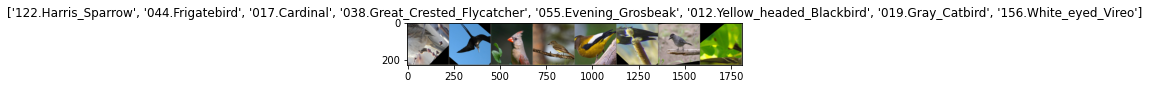

In [10]:
# CHECK CUSTOM DATALOADER
def imshow_tensors(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_main['train']))

print(inputs.shape)
print(classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_tensors(out, title=[class_names[x] for x in classes])

# LOADING TRAINED MAIN NETWORK

In [11]:
# # model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
# main_model = models.resnet50(pretrained=False)

# num_ftrs = main_model.fc.in_features
# main_model.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories

# if use_gpu:                                 # if gpu is available then use it
#     main_model = main_model.cuda()

# checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')
# main_model.load_state_dict(checkpoint['model'])
# main_model.eval() # SET MAIN NETWORK TO EVAL MODE = FREEZE MAIN NETWORK

In [12]:
main_model = resnet50()
num_ftrs = main_model.fc.in_features
main_model.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories

if use_gpu:                                 # if gpu is available then use it
    main_model = main_model.cuda()

checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')
main_model.load_state_dict(checkpoint['model'])
main_model.eval() # SET MAIN NETWORK TO EVAL MODE = FREEZE MAIN NETWORK

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# VALIDATE SAME TEST ACCURACY ON MAIN TASK
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloaders_main[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))[0]
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

top1, top5 = calc_accuracy(main_model, 'test')
top1.avg, top5.avg

(tensor(81.0321, device='cuda:0'), tensor(95.3227, device='cuda:0'))

# DEFINE EXPLANATIONS NETWORK

In [ ]:
class Resnet_Expl(torch.nn.Module):
    def __init__(self, layers=[3, 4, 6, 3], num_classes=312):
        super(Resnet_Expl, self).__init__()
        # self.main_model = main_model

        self.num_classes = num_classes
        self.layers = layers
        self._norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.dilation = 1
        self.groups = 1
        self.base_width = 64
        self.replace_stride_with_dilation = [False, False, False]
        self.block = Bottleneck
        self.zero_init_residual = False

        # self.normalize_x0 = nn.BatchNorm2d(64)
        # self.normalize_x1 = nn.BatchNorm2d(256)
        # self.normalize_x2 = nn.BatchNorm2d(512)
        # self.normalize_x3 = nn.BatchNorm2d(1024)
        # self.normalize_x4 = nn.BatchNorm2d(2048)

        self.layer1 = self._make_layer(self.block, 64, layers[0])
        self.layer2 = self._make_layer(self.block, 128, layers[1], stride=2,
                                       dilate=self.replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(self.block, 256, layers[2], stride=2,
                                       dilate=self.replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(self.block, 512, layers[3], stride=2,
                                       dilate=self.replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.expl_fc = nn.Linear(512 * self.block.expansion, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        # torch.Size([8, 64, 56, 56]) torch.Size([8, 256, 56, 56]) torch.Size([8, 512, 28, 28]) torch.Size([8, 1024, 14, 14]) torch.Size([8, 2048, 7, 7])

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x0, x1, x2, x3, x4):
        # main_predictions, x0, x1, x2, x3, x4 = main_model(x)
        # return main_predictions, x0, x1, x2, x3, x4
        
        # x0 = self.normalize_x0(x0)
        # x1 = self.normalize_x1(x1)
        # x2 = self.normalize_x2(x2)
        # x3 = self.normalize_x3(x3)
        # x4 = self.normalize_x4(x4)

        x1_own = self.layer1(x0)
        # x1_own = torch.cat((x1_own, x1), dim=1)
        x1_own = x1_own.add(x1)

        x2_own = self.layer2(x1_own)
        x2_own = x2_own.add(x2)

        x3_own = self.layer3(x2_own)
        x3_own = x3_own.add(x3)
        # print(x3[0])
        # print(x3_own[0])

        x4_own = self.layer4(x3_own)
        x4_own = x4_own.add(x4)
        # print(x4[0])
        # print(x4_own[0])

        expl_predictions = self.avgpool(x4_own)
        expl_predictions = torch.flatten(expl_predictions, 1)
        # expl_predictions = expl_predictions.view(expl_predictions.size(0), -1)
        expl_predictions  = self.expl_fc(expl_predictions)

        # print(x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, main_predictions.shape)
        # print(x0.shape, x1_own.shape, x2_own.shape, x3_own.shape, x4_own.shape, expl_predictions.shape)
        return expl_predictions

In [ ]:
expl_model = Resnet_Expl()
if use_gpu:
    expl_model = expl_model.cuda()
print(expl_model)

Resnet_Expl(
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
# DEBUGGING
for i, data in enumerate(dataloaders_expl['test']):
        inputs, labels = data
        # print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # print(labels.shape)

        # main_outputs = setex_model(inputs)
        # print(main_outputs.shape)
        # print(expl_outputs.shape)

        main_predictions, x0, x1, x2, x3, x4 = main_model(inputs)
        expl_predictions = expl_model(x0, x1, x2, x3, x4)
        print(main_predictions)
        print(expl_predictions)
        # print(main_model(inputs)[0])

        break

tensor([[-0.8686,  0.7317, -1.8064,  ...,  2.7397, -2.3814, -0.9642],
        [-0.4909, -1.0979, -1.6179,  ...,  2.0326, -1.1725,  1.7813],
        [ 0.6078, -1.9325, -0.8750,  ...,  3.2936,  4.8922,  1.8405],
        ...,
        [-1.3618, -2.2338, -3.8056,  ...,  5.6369,  4.2220, -1.9759],
        [-3.1755, -0.1411,  0.0433,  ..., -2.3745, -2.1609,  2.7986],
        [-2.1251, -1.4841, -1.1494,  ...,  0.5083, -1.5435,  4.6867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.7173, -0.5726, -0.8670,  ..., -0.4108,  0.6232, -0.6158],
        [ 0.8736, -0.4124, -0.2157,  ..., -0.3450,  0.6663, -0.1743],
        [ 0.7706, -0.1857, -0.3864,  ..., -0.8133,  0.8717, -0.1486],
        ...,
        [ 0.5524, -0.2640, -0.6369,  ..., -0.8822,  1.3672, -1.6877],
        [ 0.5493, -0.2234,  0.0438,  ..., -0.5753,  0.6955,  0.2029],
        [ 0.7498, -0.3436, -0.0962,  ..., -0.1273,  0.3785,  0.0260]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
# CHECK MAIN ACCURACY IS THE SAME AFTER CREATING SETEX MODEL
top1, top5 = calc_accuracy(main_model, 'test')
top1.avg, top5.avg

(tensor(81.0321, device='cuda:0'), tensor(95.3227, device='cuda:0'))

# TRAIN EXPLANATIONS

In [ ]:
# LOAD PRETRAINED LAYERS FROM THE MAIN MODEL

# checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')
# expl_model.load_state_dict(checkpoint['model'])

# pretrained_dict = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')['model']
# model_dict = expl_model.state_dict()
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print(pretrained_dict.keys())
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# expl_model.load_state_dict(pretrained_dict, strict=False)

checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/expl_ws_resnet50_best.pth')
expl_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
def train_expl_model(main_model, expl_model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = expl_model.state_dict()
    best_acc = 0.0

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                expl_model.train(True)  # Set model to training mode
                losses_list, accuracies_list = train_losses, train_accuracies
            else:
                expl_model.train(False)  # Set model to evaluate mode
                losses_list, accuracies_list = test_losses, test_accuracies

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders_expl[phase]:
                # get the inputs
                inputs, attributes = data
                # attributes = torch.from_numpy(attributes).float()

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    attributes = Variable(attributes.cuda())
                else:
                    inputs, attributes = Variable(inputs), Variable(attributes)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                main_predictions, x0, x1, x2, x3, x4 = main_model(inputs)
                expl_outputs = expl_model(x0, x1, x2, x3, x4)
                
                loss = criterion(expl_outputs, Variable(attributes.float()))

                preds = torch.sigmoid(expl_outputs).data > 0.5
                # print(preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() #loss.data[0]
                running_corrects += torch.sum(preds == attributes.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / (dataset_sizes[phase]*312)
            losses_list.append(epoch_loss)
            accuracies_list.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = expl_model.state_dict()
                state = {'model':expl_model.state_dict(),'optim':optimizer.state_dict()}
                # torch.save(state,'./drive/My Drive/TFM/Birds-Task-PyTorch/point_resnet18_best.pth')
                torch.save(state,'./drive/My Drive/TFM/Birds-Task-PyTorch/expl_ws_resnet50_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    expl_model.load_state_dict(best_model_wts)

    # Return best model and statistics
    train_losses, train_accuracies = np.array(train_losses), np.array(train_accuracies)
    test_losses, test_accuracies = np.array(test_losses), np.array(test_accuracies)
    stats = {'train_loss':train_losses, 'train_acc':train_accuracies, 'test_loss':test_losses, 'test_acc':test_accuracies}
    return expl_model, stats

In [ ]:
pos_weights_vector = pos_weights_vector.to(device='cuda') if use_gpu else pos_weights_vector
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights_vector)
# optimizer = optim.Adam(expl_model.parameters(), lr=1e-5)
optimizer = optim.SGD(expl_model.parameters(), lr=1e-5)

expl_model, stats = train_expl_model(main_model, expl_model, criterion, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.1029 Acc: 0.7801
test Loss: 0.1261 Acc: 0.7759

Epoch 1/29
----------
train Loss: 0.1019 Acc: 0.7795
test Loss: 0.1276 Acc: 0.7794

Epoch 2/29
----------
train Loss: 0.1025 Acc: 0.7789
test Loss: 0.1266 Acc: 0.7765

Epoch 3/29
----------
train Loss: 0.1019 Acc: 0.7794
test Loss: 0.1271 Acc: 0.7784

Epoch 4/29
----------
train Loss: 0.1031 Acc: 0.7796
test Loss: 0.1263 Acc: 0.7742

Epoch 5/29
----------
train Loss: 0.1025 Acc: 0.7794
test Loss: 0.1288 Acc: 0.7766

Epoch 6/29
----------
train Loss: 0.1025 Acc: 0.7794
test Loss: 0.1268 Acc: 0.7756

Epoch 7/29
----------
train Loss: 0.1027 Acc: 0.7796
test Loss: 0.1264 Acc: 0.7753

Epoch 8/29
----------
train Loss: 0.1026 Acc: 0.7794
test Loss: 0.1268 Acc: 0.7740

Epoch 9/29
----------
train Loss: 0.1024 Acc: 0.7796
test Loss: 0.1271 Acc: 0.7790

Epoch 10/29
----------
train Loss: 0.1027 Acc: 0.7793
test Loss: 0.1267 Acc: 0.7769

Epoch 11/29
----------
train Loss: 0.1022 Acc: 0.7794
test Loss: 0.1267 Acc

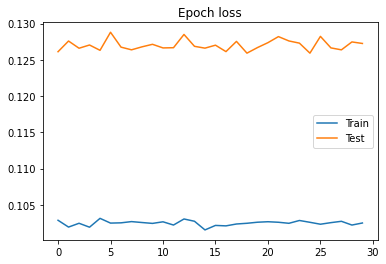

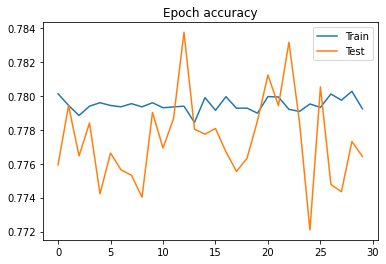

In [ ]:
# SHOW LOSS AND ACCURACIES CURVES
plt.plot(stats['train_loss'], label='Train')
plt.plot(stats['test_loss'], label='Test')
plt.title('Epoch loss')
plt.legend()
plt.show()

plt.plot(stats['train_acc'], label='Train')
plt.plot(stats['test_acc'], label='Test')
plt.title('Epoch accuracy')
plt.legend()
plt.show()

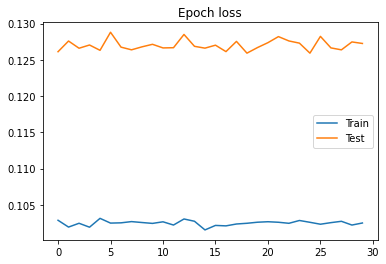

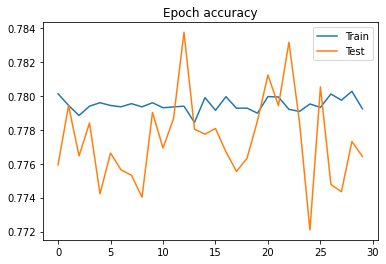

In [ ]:
# SHOW LOSS AND ACCURACIES CURVES
plt.plot(stats['train_loss'], label='Train')
plt.plot(stats['test_loss'], label='Test')
plt.title('Epoch loss')
plt.legend()
plt.show()

plt.plot(stats['train_acc'], label='Train')
plt.plot(stats['test_acc'], label='Test')
plt.title('Epoch accuracy')
plt.legend()
plt.show()

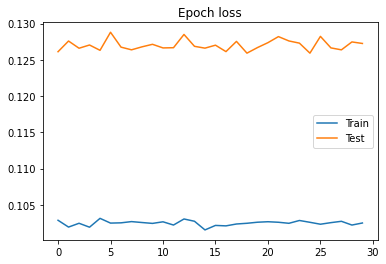

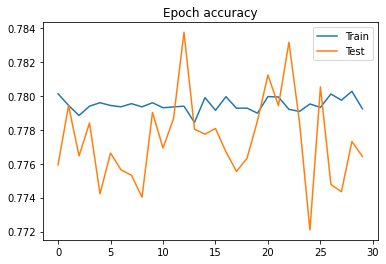

In [ ]:
# SHOW LOSS AND ACCURACIES CURVES
plt.plot(stats['train_loss'], label='Train')
plt.plot(stats['test_loss'], label='Test')
plt.title('Epoch loss')
plt.legend()
plt.show()

plt.plot(stats['train_acc'], label='Train')
plt.plot(stats['test_acc'], label='Test')
plt.title('Epoch accuracy')
plt.legend()
plt.show()